# Script for generating graphs for KAE EnKF Paper section 4.3.2: KAE EnKF vs other DMD variants - multiple frequencies

In [1]:
#Copy this script and then edit to make specific to your dataset for parameter tweaking
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pickle
import matplotlib.pyplot as plt
import seaborn as sb

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import numpy as np
from scipy.sparse.linalg import svds
import cmath
from sklearn.preprocessing import PolynomialFeatures
import itertools

from libraries.KAE import KoopmanAE, KEDcoder, LinearKoopmanLayer, LuschLoss, gen_jordan_rotation_matrix
from libraries.DMDEnKF import EnKF
import simple_sin_helpers as ssf

### Generate example synthetic data trajectory and plot

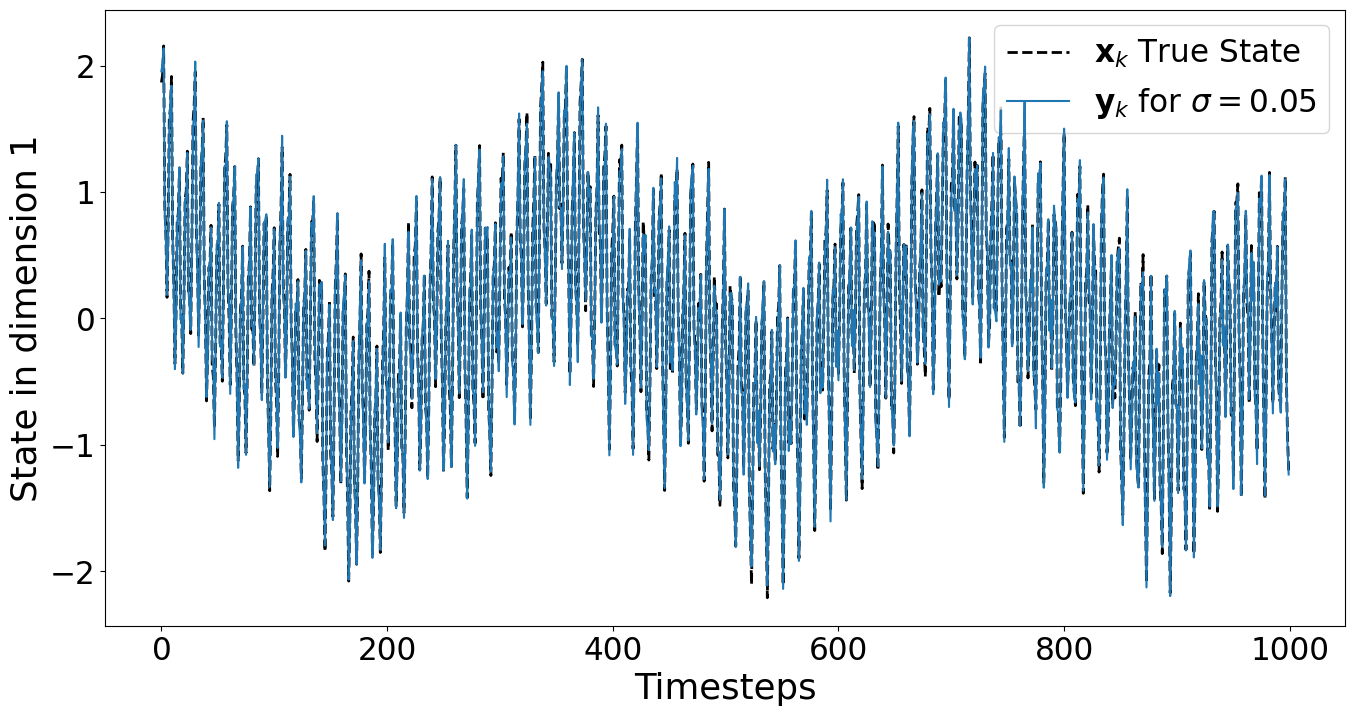

In [3]:
#example noise data plot

#data generation
num_data = 1000
num_spinup = 200
theta_start = [2*np.pi/7,2*np.pi/30,2*np.pi/356]
theta_end = [2*np.pi/7,2*np.pi/10,2*np.pi/356]
r_start = [1,1,1]
r_end = [1,1,1]
obs_cov = 0.05**2
data_dim = 100
power = 3

seed = 0
#Random seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)

#dataset and dataloaders
dataset = ssf.HighDimMultiFreqSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)

#do this again to ensure randomly generated measurment operator is the same for both (for graph purposes)
torch.manual_seed(seed)
np.random.seed(seed)
#dataset and dataloaders
highnoise_dataset = ssf.HighDimMultiFreqSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,0.5**2,data_dim,power)

#plt.plot(dataset.true_highdim_data.T[0], label =r'$\mathbf{x}_k$ True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(dataset.true_highdim_data.T[0], label =r'$\mathbf{x}_k$ True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(dataset.data.T[0],alpha=1, color='tab:blue',zorder=10,label=r'$\mathbf{y}_k$ for $\sigma = 0.05$')
#plt.plot(highnoise_dataset.data.T[0],alpha=0.8,color='tab:orange', label=r'$\mathbf{y}_k$ for $\sigma = 0.5$',linewidth='1')
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
#plt.savefig('graphs/multifreq_sin5_data_time_series.png',bbox_inches='tight')

### Show each of the 3 true eigenvalue argument trajectories over time

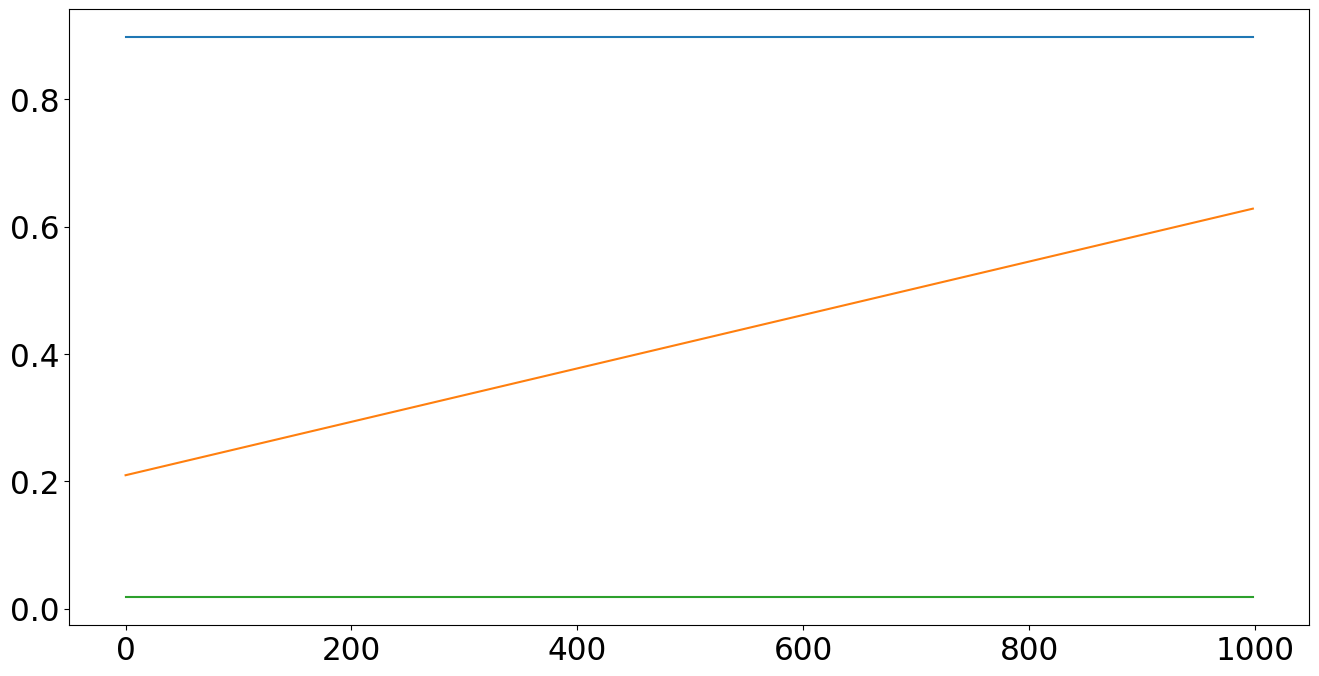

In [4]:
for t in dataset.thetas:
    plt.plot(t)

### Setup other iterative DMD variants, then train on the relevant data

In [4]:
#Parameters and set up for EDMD variants
np_data = np.array(dataset.data)

'''Time-delay Embedding'''
hankel_dim = 5
np_data = ssf.hankelify(np_data.T,hankel_dim).T
hankel_dmdenkf_num_spinup = num_spinup + 1 - hankel_dim

rank = 6
window_size = 10
system_cov_const = 0.05**2
obs_cov_const = obs_cov

eig_cov_const = 0.005**2

In [5]:
#train EDMD models
stdmds = ssf.iterate_streaming_tdmd(np_data,rank)
wtdmds = ssf.windowed_tdmd(np_data,rank,window_size)
dmdenkf = ssf.apply_dmdenkf(np_data.T,hankel_dmdenkf_num_spinup,rank,system_cov_const,obs_cov_const,eig_cov_const,ensemble_size=500)

/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/pydmd/dmdbase.py:715: UserWarning: Input data matrix X has condition number 495764.84375. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(


### Setup KAE EnKF with frequency tolerance = 0.1 as discussed in the paper and train on relevant data

In [6]:
#standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

#ALL PARAMETERS

#KAE variables
input_size = data_dim    #hardsin uses 100
num_frequencies = 3    #hard2sin uses 2
intermid_size = 10
encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,input_size)])

#training
batch_size = 128
epochs = 500
global_fourier_interval = 10
print_interval = 10


#dataset and dataloaders
train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

#Random seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
#No validation set for this example
val_dataset = ssf.HighDimMultiFreqSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
#val_dataloader = None

#initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
kae = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list,multi_freq_tol=0.1)
lossfunc = LuschLoss
#this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
#standard, linear, reconstruction, amplitude stability, regularisation
loss_hyperparameters = [1,1,1,1,0.01]
opt = optim.AdamW(kae.parameters(),lr=0.01)
'''No svd init used in this example due to lower dimension of input data than layer size'''
U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
U = torch.from_numpy(U.astype(np.float32).copy())
kae.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

#Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
kae = kae.to(dev)
kae.device = dev
kae.linear_koopman_layer.device = dev

#TRAINING LOOP
kae.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

0
tensor([1., 1., 1.])
tensor([0.2169, 5.2460, 3.0164])
First Choice: 0.19219977302273483
New Frequency: 0.19219977302273483
First Choice: 4.878379693449778
New Frequency: 4.878379693449778
First Choice: 6.077007368846107
New Frequency: 5.989643835653954
Train Loss: 2.7457501888275146
Val Loss: 0.6405385732650757
10
tensor([1.0011, 0.9979, 1.0019])
tensor([0.0448, 4.7971, 6.1131])
Train Loss: 2.0387734174728394
Val Loss: 0.49645473062992096
First Choice: 0.10483623983058264
New Frequency: 0.06290174389834959
First Choice: 0.3634322980793531
New Frequency: 0.3634322980793531
First Choice: 6.035072872913874
New Frequency: 6.035072872913874
20
tensor([0.9894, 0.9989, 0.9930])
tensor([0.0514, 0.2998, 6.0405])
Train Loss: 1.247193992137909
Val Loss: 0.39766423404216766
First Choice: 6.283185307179586
New Frequency: 6.283185307179586
First Choice: 4.97622685062499
New Frequency: 4.97622685062499
First Choice: 6.028083790258502
New Frequency: 6.028083790258502
30
tensor([0.9987, 0.9989, 1.001

400
tensor([1.0008, 1.0009, 0.9999])
tensor([6.2977, 5.3922, 6.0389])
Train Loss: 0.16355177015066147
Val Loss: 0.049350228160619736
410
tensor([1.0026, 1.0028, 0.9964])
tensor([6.2955, 5.3893, 6.0325])
Train Loss: 0.15953340381383896
Val Loss: 0.05013872869312763
420
tensor([0.9990, 1.0011, 1.0011])
tensor([6.2979, 5.3815, 6.0287])
Train Loss: 0.15508157759904861
Val Loss: 0.04951251111924648
430
tensor([1.0001, 0.9983, 0.9995])
tensor([6.2961, 5.3902, 6.0250])
Train Loss: 0.1690804809331894
Val Loss: 0.04601913318037987
440
tensor([0.9993, 1.0011, 1.0005])
tensor([6.2989, 5.3854, 6.0293])
Train Loss: 0.15714488178491592
Val Loss: 0.047384701669216156
First Choice: 6.283185307179586
New Frequency: 6.283185307179586
First Choice: 5.385088185964261
New Frequency: 5.385088185964261
First Choice: 6.042061955569246
New Frequency: 6.042061955569246
450
tensor([1.0012, 1.0008, 0.9983])
tensor([6.2876, 5.3793, 6.0323])
Train Loss: 0.16862193495035172
Val Loss: 0.0533102136105299
460
tensor([1

In [7]:
sys_cov_const = 0.05**2
param_cov_consts = np.array([0.0005**2,0.005**2])
obs_cov_const = obs_cov
init_cov_const = obs_cov_const

kaeenkf = ssf.apply_kae_enkf_filter(kae,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)

### Setup KAE EnKF with no frequency tolerance as discussed in the paper and train on relevant data

In [12]:
#standard setup, needed to be done before parameter tweaking to ensure all vars set correctly

#ALL PARAMETERS

#KAE variables
input_size = data_dim    #hardsin uses 100
num_frequencies = 3    #hard2sin uses 2
intermid_size = 10
encoder_module_list = nn.ModuleList([nn.Linear(input_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,num_frequencies*2)])
decoder_module_list = nn.ModuleList([nn.Linear(num_frequencies*2,intermid_size),nn.ReLU(),nn.Linear(intermid_size,intermid_size),nn.ReLU(),nn.Linear(intermid_size,input_size)])

#training
batch_size = 128
epochs = 500
global_fourier_interval = 10
print_interval = 10


#dataset and dataloaders
train_dataloader = DataLoader(dataset=dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)

#Random seeds for reproducibility
torch.manual_seed(seed)
np.random.seed(seed)
#No validation set for this example
val_dataset = ssf.HighDimMultiFreqSinDataset(num_data,num_spinup,theta_start,theta_end,r_start,r_end,obs_cov,data_dim,power)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
#val_dataloader = None

#initialise Koopman AE, loss function and optimiser and attatch them to the KAE class
kae2 = KoopmanAE(input_size,num_frequencies,encoder_module_list,decoder_module_list,multi_freq_tol=0)
lossfunc = LuschLoss
#this is a variable used for setting weightings of loss function components (a1,a2,a3,a4,a5)
#standard, linear, reconstruction, amplitude stability, regularisation
loss_hyperparameters = [1,1,1,1,0.01]
opt = optim.AdamW(kae2.parameters(),lr=0.01)
'''No svd init used in this example due to lower dimension of input data than layer size'''
U, _, _ = svds(np.array(dataset.spinup_data).T,k=intermid_size)
U = torch.from_numpy(U.astype(np.float32).copy())
kae2.set_training_attributes(opt,lossfunc,loss_hyperparameters,train_dataloader,val_dataloader=val_dataloader,svd_init=None)

#Move to GPU (sadly needed to be done this way for JIT compiler compatibility)
dev = 'cuda' if torch.cuda.is_available() else 'cpu'
kae2 = kae2.to(dev)
kae2.device = dev
kae2.linear_koopman_layer.device = dev

#TRAINING LOOP
kae2.run_training_loop(epochs,global_fourier_interval=global_fourier_interval,print_interval=print_interval)

0
tensor([1., 1., 1.])
tensor([0.2169, 5.2460, 3.0164])
First Choice: 0.23762881028265398
New Frequency: 0.23762881028265398
First Choice: 3.365243298561703
New Frequency: 3.365243298561703
First Choice: 6.090985534156852
New Frequency: 6.090985534156852
Train Loss: 2.7157387733459473
Val Loss: 0.6354895234107971
10
tensor([0.9983, 1.0011, 0.9987])
tensor([0.1640, 3.4509, 6.1950])
Train Loss: 2.5470759868621826
Val Loss: 0.6069742143154144
First Choice: 6.220283563281237
New Frequency: 6.220283563281237
First Choice: 0.10483623983058264
New Frequency: 0.10483623983058264
First Choice: 0.038439954604546966
New Frequency: 0.038439954604546966
20
tensor([0.9976, 1.0018, 0.9977])
tensor([6.2168, 0.0275, 0.0534])
Train Loss: 2.145197033882141
Val Loss: 0.5480504333972931
First Choice: 6.174854526021317
New Frequency: 6.174854526021317
First Choice: 6.171359984693631
New Frequency: 6.171359984693631
First Choice: 6.283185307179586
New Frequency: 6.283185307179586
30
tensor([0.9993, 1.0012, 1

Train Loss: 0.3715364784002304
Val Loss: 0.12956949695944786
410
tensor([0.9986, 0.9990, 0.9989])
tensor([6.1095, 5.3940, 5.5640])
Train Loss: 0.3589738756418228
Val Loss: 0.10798389837145805
420
tensor([0.9976, 1.0012, 0.9982])
tensor([6.1047, 5.3899, 5.5281])
Train Loss: 0.35323645174503326
Val Loss: 0.1160428375005722
430
tensor([0.9952, 1.0001, 1.0027])
tensor([6.1045, 5.3914, 5.4842])
Train Loss: 0.3756161779165268
Val Loss: 0.10847754776477814
440
tensor([0.9984, 1.0005, 0.9987])
tensor([6.1033, 5.3949, 5.4600])
Train Loss: 0.36433742940425873
Val Loss: 0.11254186928272247
First Choice: 6.111952782122968
New Frequency: 6.111952782122968
First Choice: 5.388582727291947
New Frequency: 5.388582727291947
First Choice: 2.512575214606297
New Frequency: 2.512575214606297
450
tensor([1.0005, 1.0007, 0.9990])
tensor([6.1037, 5.3885, 2.5146])
Train Loss: 0.36577892303466797
Val Loss: 0.11397076025605202
460
tensor([0.9995, 0.9996, 0.9997])
tensor([6.1031, 5.3986, 2.5267])
Train Loss: 0.363

In [13]:
sys_cov_const = 0.05**2
param_cov_consts = np.array([0.0005**2,0.005**2])
obs_cov_const = obs_cov
init_cov_const = obs_cov_const

kaeenkf2 = ssf.apply_kae_enkf_filter(kae2,dataset.filter_data,sys_cov_const,param_cov_consts,obs_cov_const,init_cov_const,ensemble_size = 100)

### Show how model estimated frequencies change during training with/without frequency tolerance

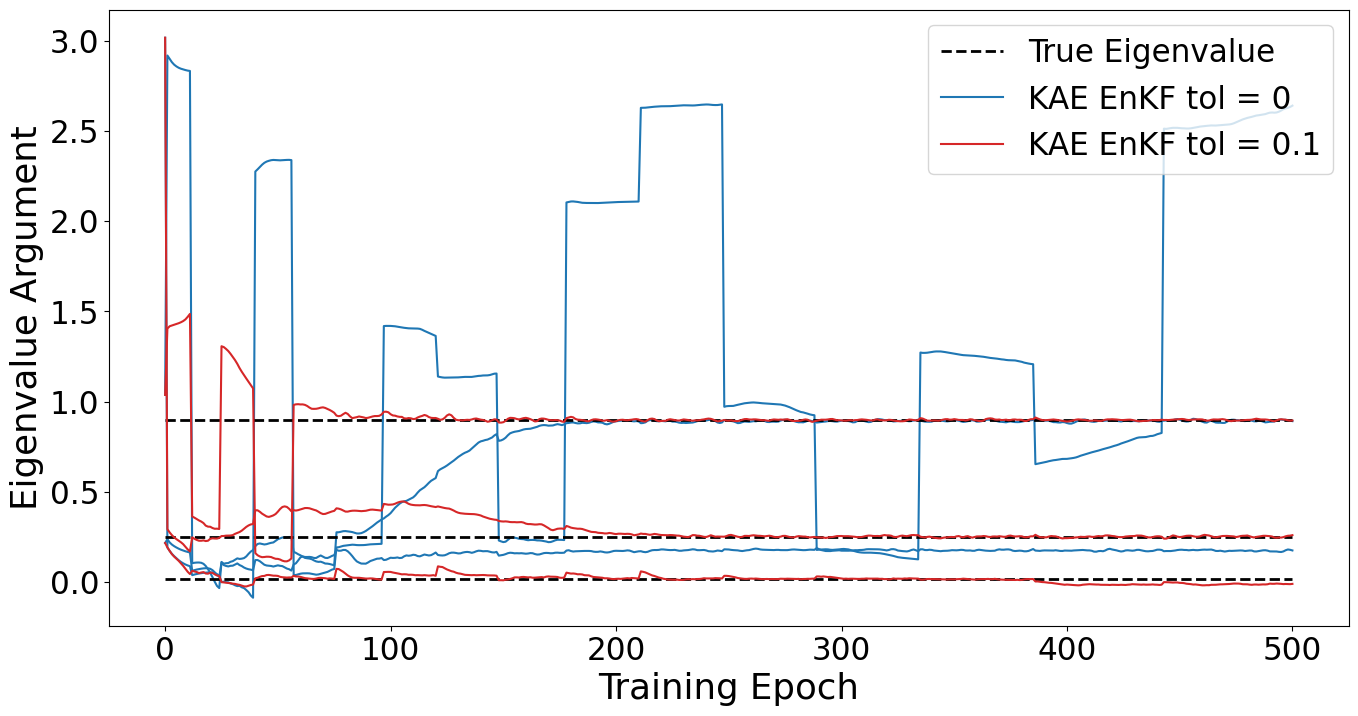

In [63]:
#Plot kaeenkf while fitting with and without manual frequency repulsion

for i,t in enumerate(dataset.thetas):
    if i == 0:
        lab = 'True Eigenvalue'
    else:
        lab = None
    plt.hlines(t[100],0,500,color='black',linestyles='--',linewidth=2,label=lab)

for i,f in enumerate(np.vstack(kae2.linear_koopman_layer.frequency_tracker).T):
    if i == 0:
        lab = 'KAE EnKF tol = 0'
    else:
        lab = None
    plt.plot([(2*np.pi - s) if abs(s)>np.pi else s for s in f],c='tab:blue',label=lab,zorder=-5)    
    
for i,f in enumerate(np.vstack(kae.linear_koopman_layer.frequency_tracker).T):
    if i == 0:
        lab = 'KAE EnKF tol = 0.1'
    else:
        lab = None
    plt.plot([(2*np.pi - s) if abs(s)>np.pi else s for s in f],c='tab:red',label=lab,alpha=1)
    
plt.xlabel('Training Epoch')
plt.ylabel('Eigenvalue Argument')
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[2],handles[0],handles[1]], [labels[2],labels[0],labels[1]],loc='upper right')
plt.savefig('graphs/multifreq_kae_training_freqs.png',bbox_inches='tight')

### Show how eigenvalue argument estimates change over time for each model

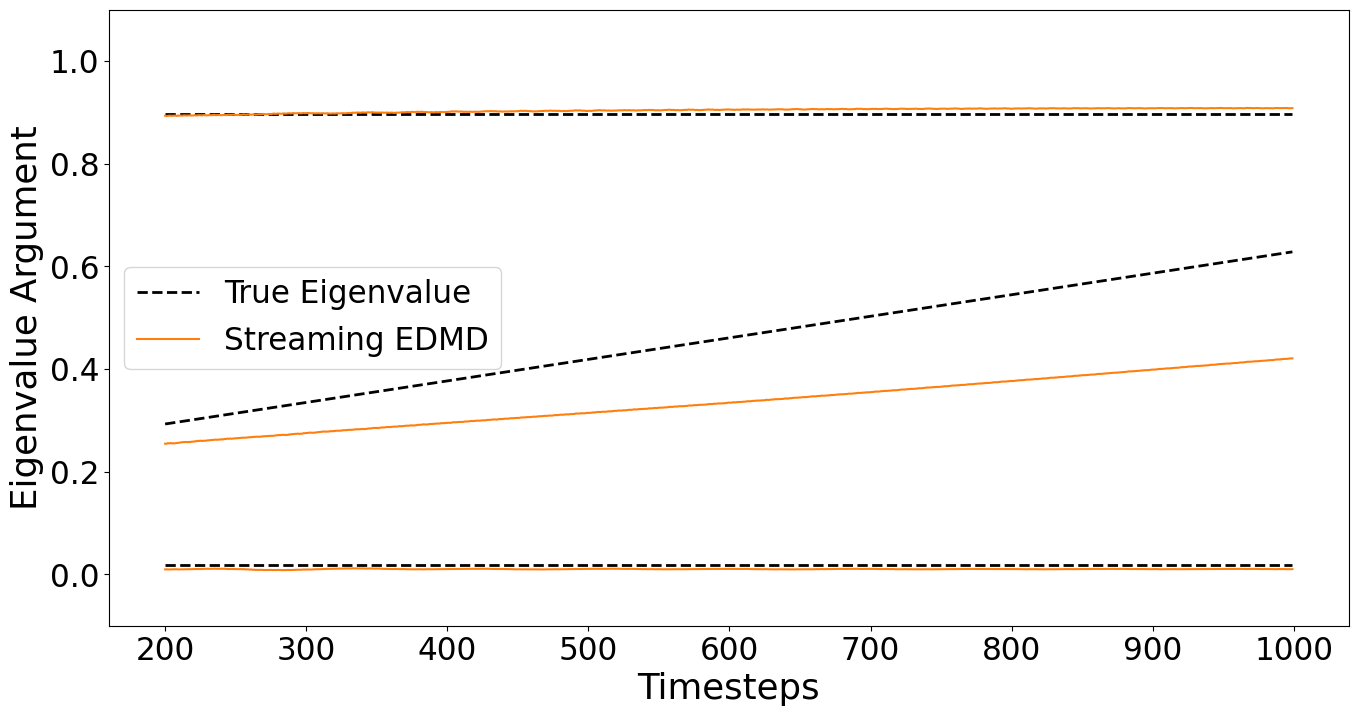

In [73]:
num_to_keep = num_data-num_spinup
x = range(200,1000)
for i, thetas in enumerate(dataset.thetas):
    if i == 0:
        lab = 'True Eigenvalue'
    else:
        lab = None
    plt.plot(x,thetas[-num_to_keep:],c='black',linewidth='2', ls='--',zorder=1,label=lab)
sedmd_eigs = [s.eigs for s in stdmds[-num_to_keep:]]
for i in [0,2,4]:
    if i == 0:
        lab = 'Streaming EDMD'
    else:
        lab = None
    plt.plot(x,[cmath.polar(eigs[i])[1] for eigs in sedmd_eigs],label=lab,c='tab:orange',zorder=2)
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
plt.ylim(-0.1,1.1)
plt.savefig('graphs/multifreq_sedmd_eigarg_trajectory.png',bbox_inches='tight')

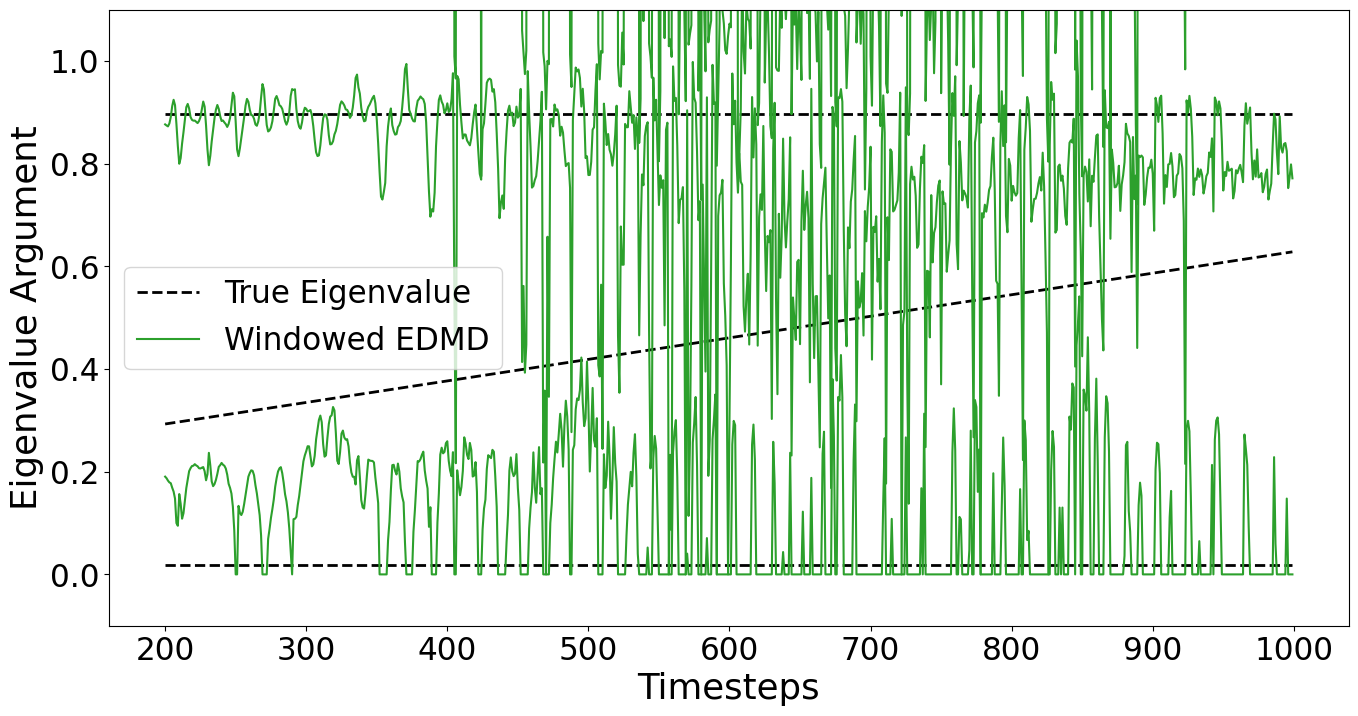

In [74]:
num_to_keep = num_data-num_spinup
x = range(200,1000)

for i, thetas in enumerate(dataset.thetas):
    if i == 0:
        lab = 'True Eigenvalue'
    else:
        lab = None
    plt.plot(x,thetas[-num_to_keep:],c='black',linewidth='2', ls='--',zorder=1,label=lab)
    
wedmd_eigs = [s.eigs for s in wtdmds[-num_to_keep:]]
def wedmd_eig_preplot(eig_timestep):
    return sorted([abs(cmath.polar(e)[1]) for e in eig_timestep])
wedmd_eigs = [wedmd_eig_preplot(eigs) for eigs in wedmd_eigs]
for i in [0,2,4]:
    if i == 0:
        lab = 'Windowed EDMD'
    else:
        lab = None
    plt.plot(x,[eigs[i] for eigs in wedmd_eigs],label=lab,c='tab:green',zorder=2)
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
plt.ylim(-0.1,1.1)
plt.savefig('graphs/multifreq_wedmd_eigarg_trajectory.png',bbox_inches='tight')

/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


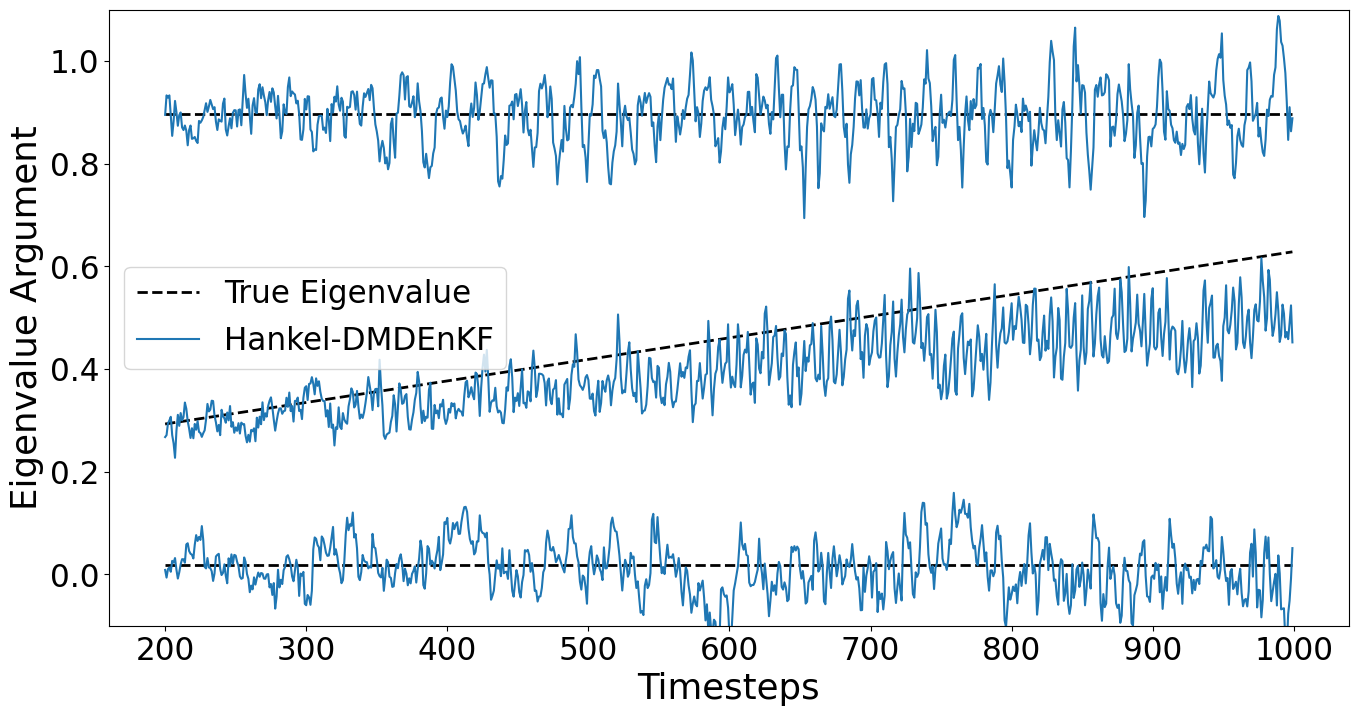

In [75]:
num_to_keep = num_data-num_spinup
x = range(200,1000)
for i, thetas in enumerate(dataset.thetas):
    if i == 0:
        lab = 'True Eigenvalue'
    else:
        lab = None
    plt.plot(x,thetas[-num_to_keep:],c='black',linewidth='2', ls='--',zorder=1,label=lab)
    
dmdenkf_eigs = [d[-6:] for d in dmdenkf.X[-num_to_keep:]]
for i in [1,3,5]:
    if i == 1:
        lab = 'Hankel-DMDEnKF'
    else:
        lab = None
    plt.plot(x,[eigs[i] for eigs in dmdenkf_eigs],label=lab,c='tab:blue',zorder=2)
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
plt.ylim(-0.1,1.1)
plt.savefig('graphs/multifreq_dmdenkf_eigarg_trajectory.png',bbox_inches='tight')

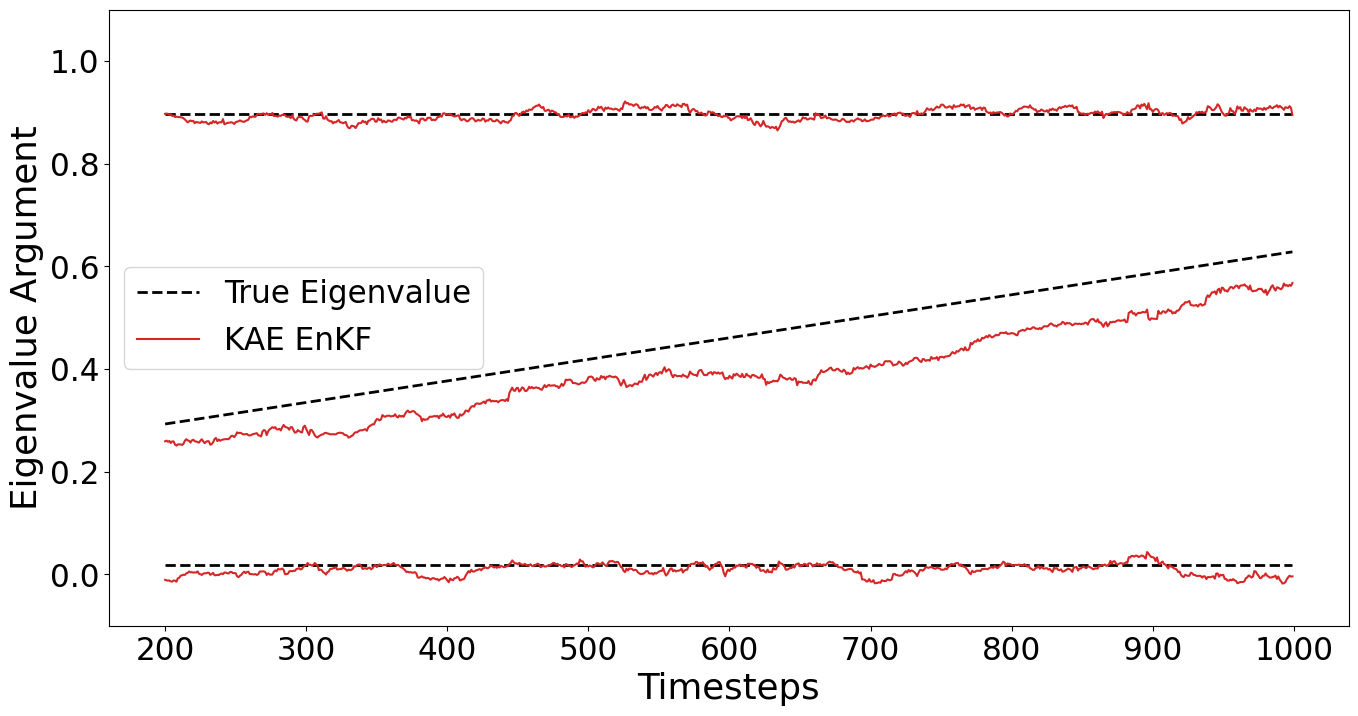

In [108]:
num_to_keep = num_data-num_spinup
x = range(200,1000)
for i, thetas in enumerate(dataset.thetas):
    if i == 0:
        lab = 'True Eigenvalue'
    else:
        lab = None
    plt.plot(x,thetas[-num_to_keep:],c='black',linewidth='2', ls='--',zorder=1,label=lab)
    
kaeenkf_eigs = [d[-6:] for d in kaeenkf.X[-num_to_keep:]]
for i in [1,2,3]:
    if i == 1:
        lab = 'KAE EnKF'
    else:
        lab = None
    plt.plot(x,[(2*np.pi - s[-i]) if abs(s[-i])>np.pi else s[-i] for s in kaeenkf_eigs],label=lab, c='tab:red',zorder=2)
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('Eigenvalue Argument')
plt.ylim(-0.1,1.1)
plt.savefig('graphs/multifreq_kaeenkf_eigarg_trajectory.png',bbox_inches='tight')

### Show eigenvalue modulus error distributions for each model

/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displ

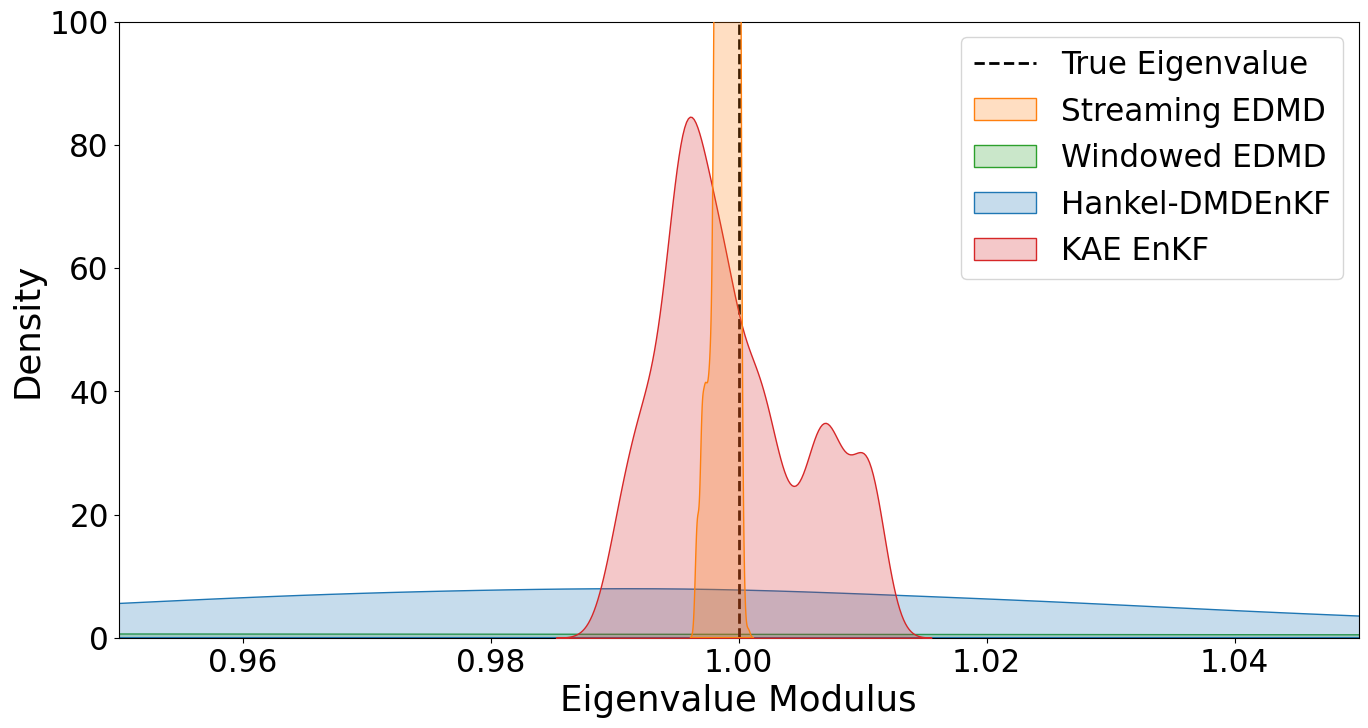

In [112]:
sedmd_mods = np.hstack([[eigs[0], eigs[2], eigs[4]] for eigs in sedmd_eigs])
sedmd_mods = [cmath.polar(m)[0] for m in sedmd_mods]
wedmd_mods = np.hstack([[eigs[0], eigs[2], eigs[4]] for eigs in wedmd_eigs])
wedmd_mods = [cmath.polar(m)[0] for m in wedmd_mods]
dmdenkf_mods = np.hstack([[eigs[0], eigs[2], eigs[4]] for eigs in dmdenkf_eigs])
kaeenkf_mods = np.hstack([[eigs[0], eigs[1], eigs[2]] for eigs in kaeenkf_eigs])

sb.distplot(sedmd_mods,hist=False,kde=True,kde_kws = {'shade': True,'zorder':4},color='tab:orange',label='Streaming EDMD')
sb.distplot(wedmd_mods,hist=False,kde=True,kde_kws = {'shade': True,'zorder':1},color='tab:green',label='Windowed EDMD')
sb.distplot(dmdenkf_mods,hist=False,kde=True,kde_kws = {'shade': True,'zorder':2},color='tab:blue',label='Hankel-DMDEnKF')
sb.distplot(kaeenkf_mods,hist=False,kde=True,kde_kws = {'shade': True,'zorder':3},color='tab:red',label='KAE EnKF')
plt.vlines(1,0,1000,linewidth=2,linestyle='--',color='black',label='True Eigenvalue')
plt.ylim(0, 100)
plt.xlim(0.95,1.05)
handles, labels = plt.gca().get_legend_handles_labels()
handys = [handles[-1]]
handys.extend(handles[:-1])
labbys = [labels[-1]]
labbys.extend(labels[:-1])
plt.xlabel('Eigenvalue Modulus')
plt.legend(handys,labbys)
plt.savefig('graphs/multifreq_edmd_eigmod_dist.png',bbox_inches='tight')

### Show forecating error distributions for each model

In [123]:
with open(f'pickles/multifreq_edmd_preds_nonlinear_sin.pkl', 'rb') as f:
    pickle_dic = pickle.load(f)
    
pickle_dic = np.hstack(pickle_dic)

true_values = pickle_dic[0]
dists = []
for preds in pickle_dic[1:]:
    dist = [(np.linalg.norm(pred-truth)**2)/len(truth) for pred,truth in zip(preds,true_values)]
    dists.append(dist)

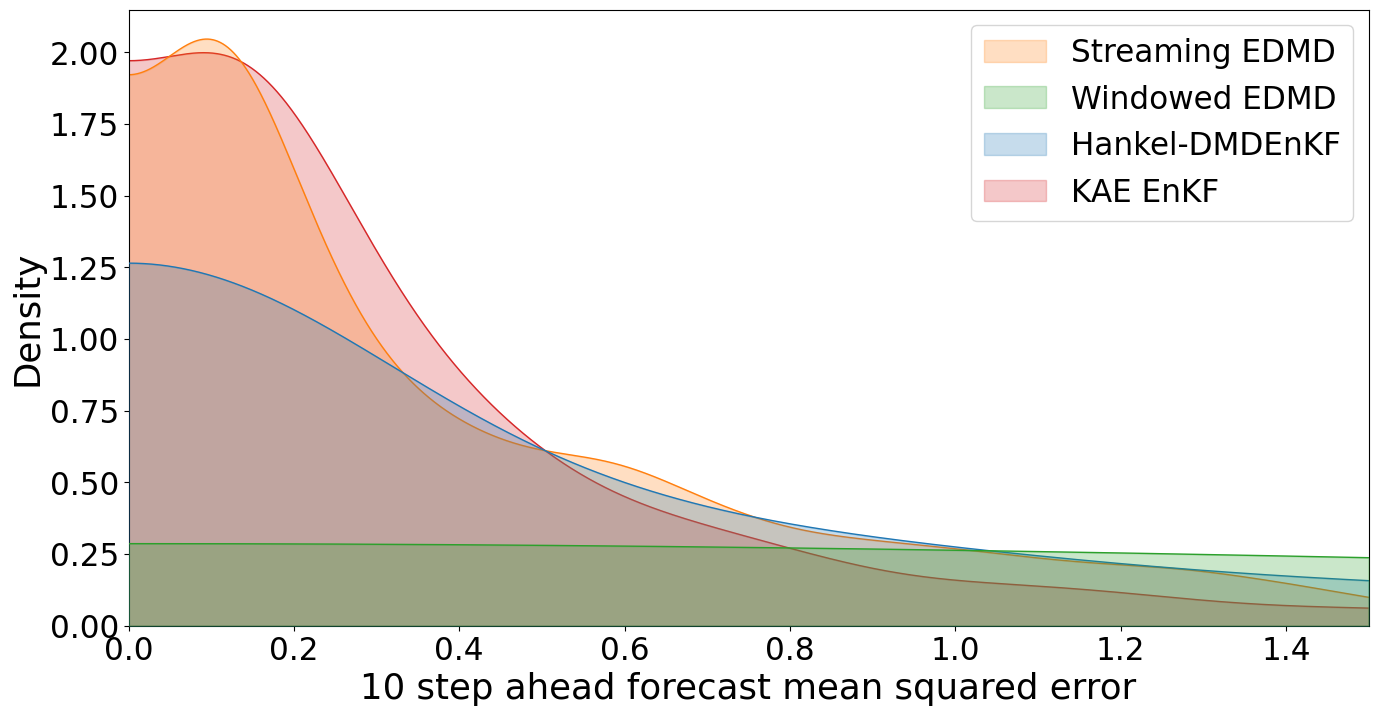

In [124]:
from scipy.stats import gaussian_kde

x_lim = 1.5
num_points = 10000
cols = ['tab:orange','tab:green','tab:blue','tab:red']
labs = ['Streaming EDMD', 'Windowed EDMD', 'Hankel-DMDEnKF', 'KAE EnKF']
zorders = [2,4,3,1]
#dist_max = max([i for j in dists for i in j])
x = np.linspace(0,x_lim,num_points)
for i,dist in enumerate(dists):
    kde = gaussian_kde(dist)
    boundary_reflect_kde = (kde(x)+kde(-x))
    plt.plot(x,boundary_reflect_kde,c=cols[i],linewidth=1,zorder=zorders[i])
    plt.fill_between(x,boundary_reflect_kde,0,alpha=0.25,color=cols[i],
                     label=labs[i],zorder=zorders[i])
plt.xlabel('10 step ahead forecast mean squared error')
plt.ylabel('Density')
plt.ylim(0)
plt.xlim(0,x_lim)
plt.legend()
#plt.savefig('graphs/multifreq_edmd_forecast_mse_dist.png',bbox_inches='tight')